# Estimates of Value-at-Risk for shares of a Bucharest Stock Exchange-traded company, 2015-2019

**Author:** Nicholas VJ Alexander


In [57]:
%reset -f
!pip -q install nbconvert
!pip -q install ipython
!pip -q install yfinance
!pip -q install matplotlib
!pip -q install cryptography
import requests, getpass, base64, os, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import Markdown as md
from datetime import datetime
from scipy.stats import norm, t, binom, binomtest, skew, kurtosis, chi2, binom_test
from scipy.special import gamma
from scipy.integrate import quad
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes

In [58]:
currtime = datetime.now().strftime('%Y-%m-%d %H:%M UTC')
md(f"**Most recently updated:** {currtime}")

**Most recently updated:** 2024-01-21 09:44 UTC


**Contact:** https://www.linkedin.com/in/nvalexander

---

**Abstract:**

This working paper tests several methods of estimation for Value-at-Risk (VaR), comparing their performance with the actual findings over the subsequent 12 months.

---

**Disclaimer:**

This file is work in progress. As long as this disclaimer is included, its results are not to be assumed as correct.

---


The European Union is at the forefront of global banking reforms aimed at mitigating risks in the private banking system. Additionally, the core objective of the European Banking Authority is a transparent banking environment. To these goals, Directive 2013/36/EU of the European Parliament and of the Council, and its implementation, Commission Implementing Regulation (eu) 2019/912, require adherence to Basel III rules across the EU member states. The latter's Annex 4 requires Credit Institutions disclose, every year, "Own funds requirements for market risk" using "standardized methods".

The strictness of these regulations is merely a façade. The current Basel framework approach, in the section "MAR33. Internal models approach: capital requirements calculation", states that "supervisors may permit banks to use models based on either historical simulation, Monte Carlo simulation, or other appropriate analytical methods". Hence, in this working paper, I will test several methods for estimating Value-at-Risk (VaR) in a hypothetical portfolio comprising a single type of equity, namely a company traded on the Bucharest Stock Exchange.

In broad terms, Value at Risk (VaR) serves as a benchmark to quantify potential losses within extreme scenarios. For instance, when employing a 95% confidence level, VaR represents the minimum percentage loss that could occur on the most unfavorable 5% of trading days for the analyzed portfolio. Recognizing that VaR still describes an optimistic scenario, regulatory guidelines also mandate the computation of Expected Shortfall (ES), which represents the average percentage losses anticipated on those lowest 5% of days. Per RiskMetrics Technical Document, J.P. Morgan/Reuters, 4th ed, 1996: 
 
\begin{equation}
VaR = max(X_i| X_i \in W)
\end{equation}

Per Coherent Measures of Risk, Artzner & Delbaen & Eber & Heath, 1999, https://doi.org/10.1111/1467-9965.00068:

\begin{equation}
ES = E[X_i| X_i \in W]
\end{equation}

In both cases, W is the subset of Xi generally termed Worst Case Scenario, and most commonly defined as a function of a 

\begin{equation}
W = \{X_i |  X_i \leq Q_{1-\alpha}(X) \}
\end{equation}

Note that, throughout this paper, we will describe VaR and ES as raw estimates, on the same scale as the returns that they are derived from, rather than changing sign, applying to the price of a share and / or applying to a hypothetical portfolio of a given value or content.

## Data collection

Closing values for the interval 2015-2019 were obtained using an HTTP scraper written by the author. As it not clear whether scraping bvb.ro data is in agreement with its rules, I protected a trivial section of the scraper with a password in the code posted on Github. Closing values were convered to percent change.

In [137]:
cache_file = 'data/cache.pkl'
ticker = 'EL'
startdate = '2015-01-01'
enddate = '2020-01-01'
n_simulations_kuiper = 10000
alpha_kuiper = 0.05
confidence_level_VaR_ES = 0.95

if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
        cache = pickle.load(f)
        sharedata = cache.get('sharedata', None)
else:
    sharedata = None

def key_from_password(password: str, salt: bytes):
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=base64.urlsafe_b64decode(salt),
        iterations=100000,
        backend=default_backend()
    )
    key = base64.urlsafe_b64encode(kdf.derive(password.encode()))
    return key

def decrypt_message(encrypted_message, password, salt):
    key = key_from_password(password, salt)
    fernet = Fernet(key)
    try:
        decrypted_message = fernet.decrypt(encrypted_message.encode()).decode()
        return decrypted_message
    except:
        return None

def fetch_bvb_data(ticker, startdate, enddate):
    start_timestamp = int(datetime.strptime(startdate, '%Y-%m-%d').timestamp())
    end_timestamp = int(datetime.strptime(enddate, '%Y-%m-%d').timestamp())
    url_template = decrypt_message(
        'gAAAAABlrAl5yVctyT7ySvJckZw-Ji9CofturK9duVDA8GS'
        'G8IutAlPtLe7CBAkmuiC9aW9ICjWL6CYAhRfF5zyUiwi3FNf'
        'dFJNXzdZvX4fHgp-PWELaeHEO21GNAbd1PS-vnrvzQFeWLk'
        'gWai9TD6cchKF4Q7Dsvnqr2PF01KJXgKvpmuUln51PRMDgn3'
        'd35PBoPX4kNAZHT0Y0RiJc4RWSzMOQ4DOXRqV0ycSrI0NOjxiGX6b7BWc=',
        password,
        'vGmK5XnOd3trf7uCOa0baQ=='
    )
    url = url_template.format(ticker=ticker, start_timestamp=start_timestamp, end_timestamp=end_timestamp)
    referrer_template = decrypt_message(
        'gAAAAABlq-CfDvJGetCCbdadT9aEdRwD9AjQNL9CcYh8aINR_'
        'uiBOOrD_58SDsTN9pO0IE4twO2ohut3SMEHpFRSfskGWv6N048'
        'H3y1yKQWWhyb-kpFPuLhFA6UkkTvLcKduTBwxXFG4m8LeP-RPk'
        'Ycxi9TrHjX3uTkrFcBKIyA54XtgWcMvLr22XDeMaWLCg2bN85W5UadJ', 
        password,
        'RYGlNyoOQupNEt4l0f8IdQ=='
        )
    referrer = referrer_template.format(ticker=ticker)
    if not referrer:
        print("Incorrect password, cannot decrypt the URL.")
        return pd.DataFrame()
    headers = {'Referer': referrer}
    response = requests.get(url, headers=headers)
    del url
    del referrer
    del headers
    if response.status_code != 200:
        return pd.DataFrame()  # Returns an empty DataFrame in case of HTTP errors
    data = response.json()
    if data.get('s') != 'ok':
        return pd.DataFrame()  # Return an empty DataFrame if status is not 'ok'
    return pd.DataFrame({
        'Date': [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in data['t']],
        'Open': data['o'],
        'High': data['h'],
        'Low': data['l'],
        'Close': data['c'],
        'Volume': data['v']
    })

if sharedata is None:
    password = getpass.getpass("Enter your BVB fetcher password: ")
    sharedata = fetch_bvb_data(ticker, startdate, enddate)
    del password
    cache = {}
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cache = pickle.load(f)
    cache['sharedata'] = sharedata
    with open(cache_file, 'wb') as f:
        pickle.dump(cache, f)

sharedata['DateTime'] = pd.to_datetime(sharedata['Date'])
sharedata = sharedata.sort_values(by='DateTime')
sharedata['DailyReturn'] = sharedata['Close'].pct_change()

Plotting closing prices shows several epochs with dominant trend.

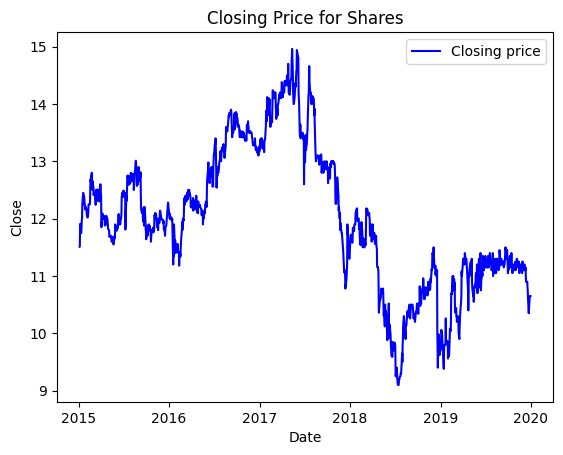

In [60]:
plt.plot(sharedata['DateTime'], sharedata['Close'], label='Closing price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Closing Price for Shares')
plt.legend()
plt.show()

Plotting the daily returns does not indicate any extreme values in the data.

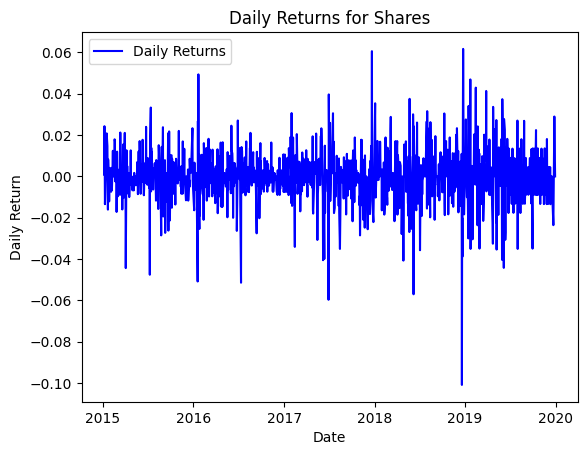

In [61]:
plt.plot(sharedata['DateTime'], sharedata['DailyReturn'], label='Daily Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns for Shares')
plt.legend()
plt.show()

The data was split into a calculation set comprising four years (2015-2018) and a verification set comprising data from 2019.

In [62]:
returns = sharedata[['DailyReturn', 'DateTime']].dropna()
train_data_with_dates = returns[(returns['DateTime'] >= '2015-01-01') & (returns['DateTime'] < '2019-01-01')]
train_data = train_data_with_dates['DailyReturn']
test_data_with_dates = returns[returns['DateTime'] >= '2019-01-01']
test_data = test_data_with_dates['DailyReturn'].dropna()
md(f"In the training dataset, daily returns spanned the interval {min(train_data) * 100:.2f}%"
   f" to {max(train_data) * 100:.2f}%, with a median of "
   f"{np.median(train_data) * 100:.2f}% and a mean of "
   f"{np.mean(train_data) * 100:.2f}%."
   )


In the training dataset, daily returns spanned the interval -10.09% to 6.17%, with a median of 0.00% and a mean of -0.01%.

Before testing the various methods of estimation for VaR, it is important to establish that the calculation data set and the verification data set come from similar distributions. One way to test it is the Kuiper test.

In [63]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

x_train, y_train = ecdf(train_data)
x_test, y_test = ecdf(test_data)
combined_x = np.unique(np.concatenate((x_train, x_test)))
y_train_interp = np.interp(combined_x, x_train, y_train, left=0, right=1)
y_test_interp = np.interp(combined_x, x_test, y_test, left=0, right=1)
D_plus = np.max(y_test_interp - y_train_interp)
D_minus = np.max(y_train_interp - y_test_interp)
kuiper_statistic = D_plus + D_minus

# There is no table of critical values for Kuiper test in standard Python
# A value will be calculated with simulations using the current data.
combined_data = np.concatenate((train_data, test_data))
kuiper_simulation_dataset = []
for _ in range(n_simulations_kuiper):
    sample1 = np.random.choice(combined_data, size=len(train_data), replace=True)
    sample2 = np.random.choice(combined_data, size=len(test_data), replace=True)
    x_sample1, y_sample1 = ecdf(sample1)
    x_sample2, y_sample2 = ecdf(sample2)
    y_sample1_interp = np.interp(combined_x, x_sample1, y_sample1, left=0, right=1)
    y_sample2_interp = np.interp(combined_x, x_sample2, y_sample2, left=0, right=1)
    D_plus = np.max(y_sample2_interp - y_sample1_interp)
    D_minus = np.max(y_sample1_interp - y_sample2_interp)
    kuiper_stat_sample = D_plus + D_minus
    kuiper_simulation_dataset.append(kuiper_stat_sample)
critical_value = np.percentile(kuiper_simulation_dataset, 100 * (1 - alpha_kuiper))

In [64]:
md(f"For the current data sets, the Kuiper statistic is {kuiper_statistic:.2f}"
   f", whereas the critical value, calculated using simulations on the merged dataset, is approximately "
   f"{critical_value:.2f}."
   )

For the current data sets, the Kuiper statistic is 0.25, whereas the critical value, calculated using simulations on the merged dataset, is approximately 0.12.

A Kuiper statistic larger than the critical value indicates that the data seen in the verification data set does not follow the same distribution as the calculation data set, a fact which is likely to impair my VaR and ES estimates, in particular invalidating the verification stage, regardless of the calculation method I would use.

Nevertheless, since the best estimates of VaR on Jan 1st, 2019 are the data points preceding this date, I will use them as such.

Finally, the returns date set may be measured in terms of fitting a normal distribution, by calculating its skewness and kurtosis.

In [110]:
train_skewness = skew(train_data)
train_kurtosis = kurtosis(train_data, fisher = True)  # Fisher's definition is that which ends with subtraction of 3
md(f"For the training data set, the skewness is {train_skewness:.2f},"
   f" and the Fisher-defined excess kurtosis is {train_kurtosis:.2f}."
   )

For the training data set, the skewness is -0.76, and the Fisher-defined excess kurtosis is 8.21.

The training data set's negative skewness suggests that instances of lower-than-average outcomes were more frequent, arguing against the use of a symmetric distribution for data modeling. Additionally, the data displays significant excess kurtosis (also called leptokurtosis), which means that it has more extreme values in its tails than a typical normal distribution would have, again pleading against a normal distribution model.

## Estimations based on the Historical Simulation method

The Historical Simulation method employs the lack of any assumptions regarding historical data. Hence, the worst 5% days from the historical data are identified. Losses incurred in the best of these days provides the upper threshold, VaR, whereas their average provides the ES.

In [118]:
VaR_HS = np.percentile(train_data, (1 - confidence_level_VaR_ES) * 100)
ES_HS = train_data[train_data <= VaR_HS].mean()

md(f"For the Historical Simulation method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_HS * 100:.2f}%**"
   f", whereas **ES is {ES_HS * 100:.2f}%**."
   )

For the Historical Simulation method, using a 95.0% confidence threshold, and daily intervals, **VaR is -1.85%**, whereas **ES is -2.98%**.

Here is a graphical representation of the Historical Simulation finding on the time course, as well as on the empirical distribution histogram.

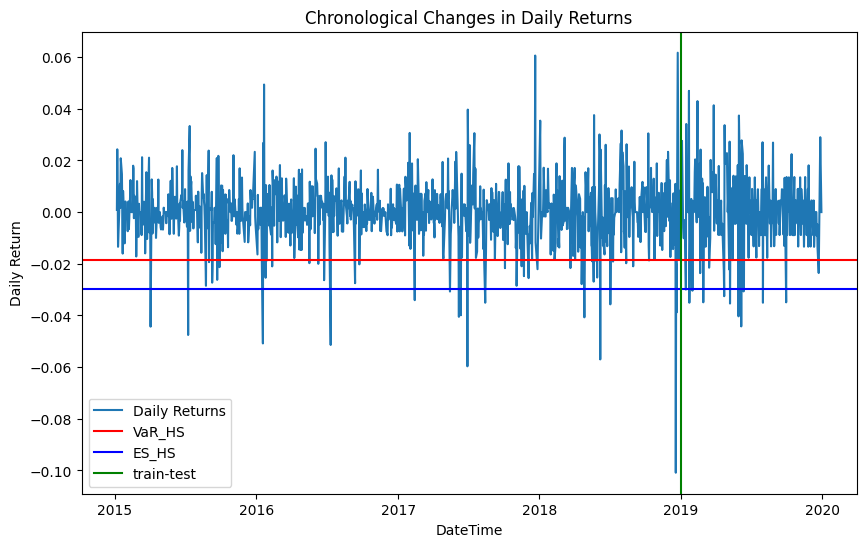

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_HS, color='r', linestyle='-', label='VaR_HS')
plt.axhline(y=ES_HS, color='b', linestyle='-', label='ES_HS')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

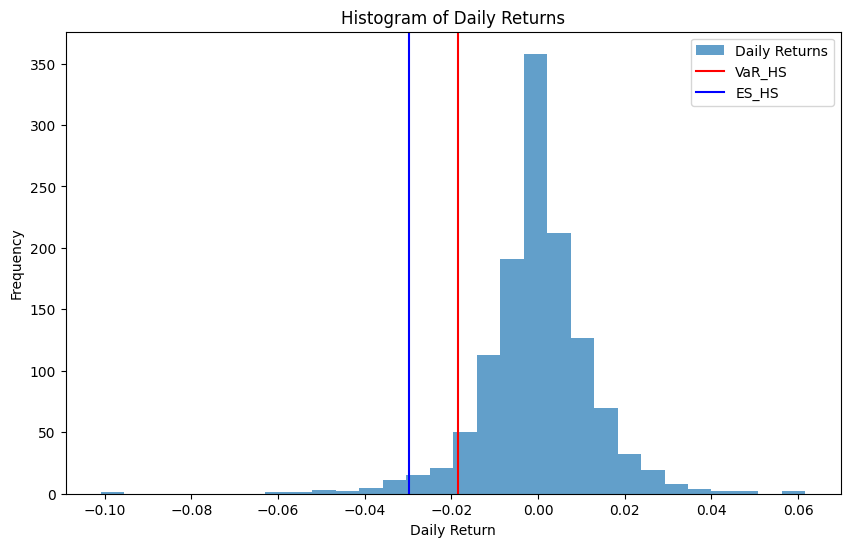

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_HS, color='r', linestyle='-', label='VaR_HS')
plt.axvline(x=ES_HS, color='b', linestyle='-', label='ES_HS')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

The performance of this estimator may be measured by comparing its predictions with the 2019 data.

In [69]:
VaR_per_testdata = np.percentile(test_data, (1 - confidence_level_VaR_ES) * 100)
ES_per_testdata = test_data[test_data <= VaR_per_testdata].mean()
expected_breaches = len(test_data) * (1 - confidence_level_VaR_ES)
observed_breaches_HS = test_data[test_data < VaR_HS].count()

md(f"The verification dataset consists of {len(test_data)} data points."
   f" For a confidence threshold of {confidence_level_VaR_ES * 100}% , we would "
   f" anticipate approximately {expected_breaches:.2f} days"
   f" in which losses would surpass the {VaR_HS * 100:.2f}% VaR estimate."
   f" However, in the year 2019, the observed count of days with losses "
   f" exceeding this VaR estimate was {observed_breaches_HS}."
   "\n\n"
   f" During the bottom {((1-confidence_level_VaR_ES) * 100):.0f}% of trading days in the verification dataset,"
   f" the average loss (corresponding to ES, estimated by the Historical Simulation method at {ES_HS * 100:.2f}%"
   f") was {ES_per_testdata * 100:.2f}%,"
   f" whereas the upper limit (similar to VaR, estimated by the Historical Simulation method at {VaR_HS * 100:.2f}%"
   f") stood at {VaR_per_testdata * 100:.2f}%."
   )


The verification dataset consists of 249 data points. For a confidence threshold of 95.0% , we would  anticipate approximately 12.45 days in which losses would surpass the -1.85% VaR estimate. However, in the year 2019, the observed count of days with losses  exceeding this VaR estimate was 18.

 During the bottom 5% of trading days in the verification dataset, the average loss (corresponding to ES, estimated by the Historical Simulation method at -2.98%) was -3.34%, whereas the upper limit (similar to VaR, estimated by the Historical Simulation method at -1.85%) stood at -2.36%.

In conclusion, the Historical Simulation method underestimated the days with losses beyond VaR, as well as losses in the worst case scenarios, both as average loss (ES) and as ceiling (VaR). 

At the simplest level, the statistical significance of the difference between prediction and observed VaR may be measured by comparing the observed frequency of days below predicted VaR and the expectations, as estimated above, and assuming a binomial distribution.

In [84]:
pvalue_binom_HS = binomtest(
  observed_breaches_HS, 
  len(test_data), 
  1 - confidence_level_VaR_ES
  ).pvalue
md(f"For this binomial test, the p value is {pvalue_binom_HS:.3f}.")

For this binomial test, the p value is 0.109.

In this context, the binomial distribution test is known as a Kupiec backtest statistic. Its null hypothesis is that the empiric frequency of breeches is predicted by a theoretical binomial (i.e., random) distribution of breeches. The data analyzed here is relatively consistent with this null hypothesis, suggesting the estimated VaR fits the findings from the test dataset.

An alternative Kupiec backtest statistic is calculated as the log-likelihood ratio:

\begin{equation}
\text{TS} = -2 \ln {\frac{p^x (1-p)^x}{(\frac{n-x}{x})^{n-x} (\frac{x}{n})^{x}}}
\end{equation}

where

- n is the total number of trials (here the number of empiric observations)
- p is the expected relative freqency of an event
- x is the observed absolute frequency of that event.

The null hypothesis in this model is, again, that the empiric frequencies are consistent with a hypothetical Binomial (n, p) distribution, that is, with a random occurence of breeches at the same rate as predicted from the estimated VaR. In order to obtain a p-value, the null hypothesis is restated as "TS is drawn from a chi-square(1) distribution". (Source: http://jaqm.ro/issues/volume-9,issue-4/4_BACIU.php)

In [112]:
def ts(n, p, x):
    LR_numerator = (1 - p)**(n - x) * p**x
    LR_denominator = (1 - x/n)**(n - x) * (x/n)**x
    LR = LR_numerator / LR_denominator
    ts = -2 * np.log(LR)
    return ts


In [120]:
ts_HS = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_HS
    )
md(f"The p value for the log-likelihood Kuipec backtest assessment of the VaR estimate is"
   f" {chi2.sf(ts_HS, 1):.2f}."
   )

The p value for the log-likelihood Kuipec backtest assessment of the VaR estimate is 0.13.

In both cases, the failure to reject the null hypothesis implies that we lack evidence to suggest a significant difference between the distribution of observed days exceeding the predicted VaR and the expected number of days with losses exceeding the predicted VaR.

A consequence of this statement is that the VaR estimates based on the Historical Simulation model are acceptable to the extent that their estimates are not inferior to a diffferent model.

## Estimations based on the Normal Distribution hypothesis

The Normal Distribution method assumes that the historical data, when assumed to be derived from a normal distribution, provide a mean and a standard deviation that may be extrapolated to future data points. In this case, the worst 5% days are identified based on the Z score. Subsequently, VaR and ES are calculated from those means and standard deviations, again using the normal distribution assumption.

In [71]:
# Normal Distribution method
mean_Normal, stddev_Normal = norm.fit(train_data)
md(f"The calculation data set fit a Normal"
   f" Distribution with a mean of "
   f" {(mean_Normal * 100):.2f}% and a standard distribution of"
   f" {(stddev_Normal * 100):.2f}%,"
   )


The calculation data set fit a Normal Distribution with a mean of  -0.01% and a standard distribution of 1.21%,

The normal distribution estimated this way is modestly similar to the observed distribution in the calculation data set, as evidenced by the following plot:

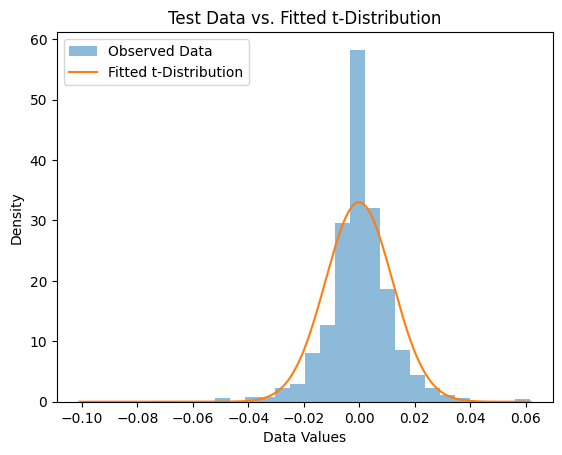

In [72]:
x_values = np.linspace(min(train_data), max(train_data), 1000)
fitted_pdf = norm.pdf(x_values, mean_Normal, stddev_Normal)
plt.hist(train_data, bins=30, density=True, alpha=0.5, label='Observed Data')
plt.plot(x_values, fitted_pdf, label='Fitted t-Distribution')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Test Data vs. Fitted t-Distribution')
plt.legend()
plt.show()

The values for mean and standard deviation are subsequently extrapolated the the predicted period of time. While the Var estimate is estimated by a specific percentile of that normal distribution, 

\begin{equation}
\text{VaR}_{\text{Normal}} = \Phi^{-1}(1 - \alpha; \mu, \sigma)
\end{equation}

ES is estimated with;

\begin{equation}
\text{ES}_{\text{Normal}} = \mu - \sigma \times \frac{\phi _{\mu, \sigma} \left(\text{VaR}_{\text{Normal}}\right)}{1 - \alpha}
\end{equation}

where
- Upper case Φ is the proportion of empiric observations falling below a given threshold, that is, the cumulative distribution function (cdf).
- Upper case Φ−1 is the value under which the observations fall, given a specific percentage of empiric observations falling below that threshold, that is, the inverse of the CDF (sometimes called PPF).
- Lower case ϕ is the probability distribution function, calculating the density of the distribution at a specific point (pdf).

In [119]:
VaR_Normal = mean_Normal + stddev_Normal * norm.ppf(1 - confidence_level_VaR_ES)
ES_Normal = mean_Normal - stddev_Normal * norm.pdf(norm.ppf(1 - confidence_level_VaR_ES)) / (1 - confidence_level_VaR_ES)
md(f"For the Normal Distribution method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_Normal * 100:.2f}%**"
   f", whereas **ES is {ES_Normal * 100:.2f}%**."
   )

For the Normal Distribution method, using a 95.0% confidence threshold, and daily intervals, **VaR is -2.00%**, whereas **ES is -2.50%**.

Here is a graphical representation of the Normal Distribution finding on the time course, as well as on the empirical distribution histogram.

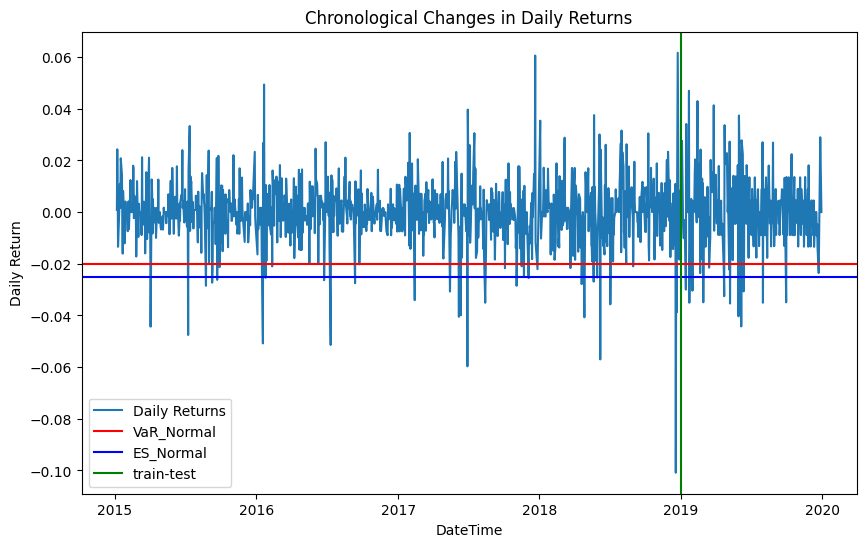

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_Normal, color='r', linestyle='-', label='VaR_Normal')
plt.axhline(y=ES_Normal, color='b', linestyle='-', label='ES_Normal')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

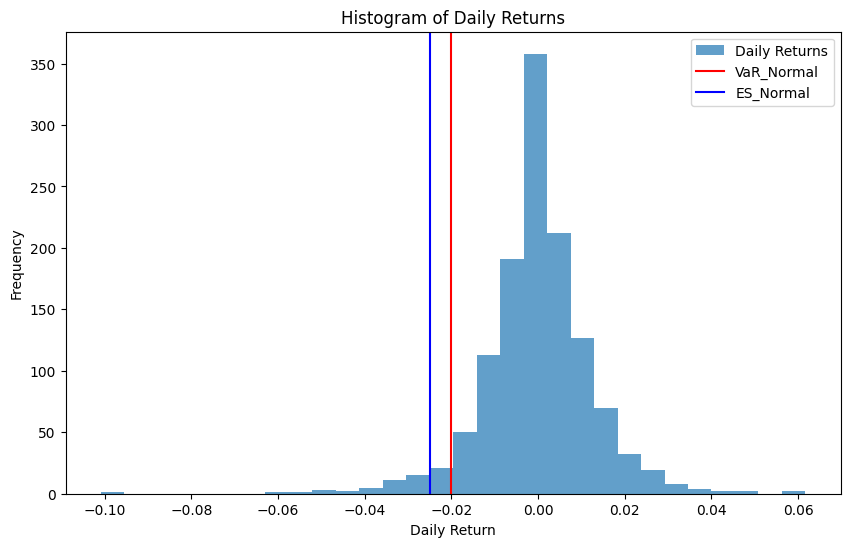

In [83]:
plt.figure(figsize=(10, 6))
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_Normal, color='r', linestyle='-', label='VaR_Normal')
plt.axvline(x=ES_Normal, color='b', linestyle='-', label='ES_Normal')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

In [122]:
observed_breaches_Normal = test_data[test_data < VaR_Normal].count()

md(f"The verification dataset consists of {len(test_data)} data points."
   f" For a confidence threshold of {confidence_level_VaR_ES * 100}% , we would "
   f" anticipate approximately {expected_breaches:.2f} days"
   f" in which losses would surpass the {VaR_Normal * 100:.2f}% VaR estimate."
   f" However, in the year 2019, the observed count of days with losses "
   f" exceeding the Normal Distribution-based VaR estimate was {observed_breaches_Normal}."
   "\n\n"
   f" During the bottom {((1-confidence_level_VaR_ES) * 100):.0f}% of trading days in the verification dataset,"
   f" the average loss (corresponding to ES, estimated by the Normal Distribution method at {ES_Normal * 100:.2f}%"
   f") was {ES_per_testdata * 100:.2f}%,"
   f" whereas the upper limit (similar to VaR, estimated by the Normal Distribution method at {VaR_Normal * 100:.2f}%"
   f") was {VaR_per_testdata * 100:.2f}%."
   )


The verification dataset consists of 249 data points. For a confidence threshold of 95.0% , we would  anticipate approximately 12.45 days in which losses would surpass the -2.00% VaR estimate. However, in the year 2019, the observed count of days with losses  exceeding the Normal Distribution-based VaR estimate was 17.

 During the bottom 5% of trading days in the verification dataset, the average loss (corresponding to ES, estimated by the Normal Distribution method at -2.50%) was -3.34%, whereas the upper limit (similar to VaR, estimated by the Normal Distribution method at -2.00%) stood at -2.36%.

The Normal Distribution method also underestimated the losses in the worst days, both as average (ES) and as ceiling (VaR). It also underestimated the number of days in which losses beyond the VaR threshold would be incurred. For validation, I compared again the number of days when losses exceeded the estimated VaR, versus our 5% expectation imposed by the confidence level, using the two Kuipec backtesting strategies described earlier.

In [114]:
pvalue_binom_Normal = binomtest(
  observed_breaches_Normal, 
  len(test_data), 
  1 - confidence_level_VaR_ES).pvalue
ts_Normal = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_Normal
    )
md(f"The p value for the log-likelihood Kuipec backtest assessment of the VaR estimate is"
   f" {chi2.sf(ts_Normal, 1):.2f} in the log-likelihood approach, and "
   f" {pvalue_binom_Normal:.2f} when using a classical binomial approach."
   )

The p value for the log-likelihood Kuipec backtest assessment of the VaR estimate is 0.21 in the log-likelihood approach, and  0.19 when using a classical binomial approach.

Again, in this context, the failure to reject the null hypothesis implies that we lack evidence to suggest a significant difference between the distribution of observed days exceeding the predicted VaR and the expected number of days with losses exceeding the predicted VaR.

Thus, the VaR estimates based on the Normal Distribution hypothesis are acceptable to the extent that their performance is not inferior to a diffferent model.

## Estimations based on the t-Student Distribution hypothesis

The t-Student Distribution method assumes that the historical data fit a t-Student distribution that may be extrapolated to future data points. The t-Student distribution is similar to the normal distribution in many aspects, such as symmetry, but it usually better suited for modelling returns, due to its heavier tails. Its PDF is given by the equation:

\begin{equation}
f(x | \nu, \mu, \sigma) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu\pi}\, \Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{1}{\nu}\left(\frac{x - \mu}{\sigma}\right)^2\right)^{-\frac{\nu + 1}{2}}
\end{equation}

where:

- x is the variable.
- ν is the degrees of freedom.
- μ is the mean of the distribution, also known as the location parameter
- σ is the standard deviation of the distribution, also known as the scale parameter
- Γ is the gamma function.

The gamma function is the extrapolation of the factorial to non-natural numbers, and is calculated with:

\begin{equation}
\Gamma(z) = \int_{0}^{\infty} t^{z-1} e^{-t} dt
\end{equation}

In this case, the first step towards calculation of VaR is the estimation of ν, μ and σ.

In [79]:
nu_t, mu_t, sigma_t = t.fit(train_data)
md(f"Calculation data fit a t-Student "
   f" Distribution with a mean of "
   f" {(mu_t * 100):.2f}%, a standard distribution of"
   f" {(sigma_t * 100):.2f}%,  and a number of "
   f" {(nu_t * 100):.2f} degrees of freedom."
   )

Calculation data fit a t-Student  Distribution with a mean of  0.02%, a standard distribution of 0.72%,  and a number of  273.32 degrees of freedom.

The estimates for ν, μ and σ yield a hypothetical t-Student Distribution rather similar to the observed data:

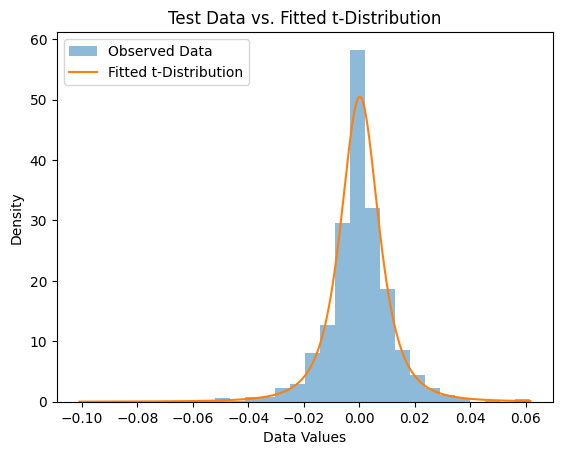

In [80]:
x_values = np.linspace(min(train_data), max(train_data), 1000)
fitted_pdf = t.pdf(x_values, nu_t, mu_t, sigma_t)
plt.hist(train_data, bins=30, density=True, alpha=0.5, label='Observed Data')
plt.plot(x_values, fitted_pdf, label='Fitted t-Distribution')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Test Data vs. Fitted t-Distribution')
plt.legend()
plt.show()


In the t-Distribution approach, the worst 5% days are identified based on the distribution of probabilities stemming from its PDF f(x | ν, μ, σ) described above. Specifically, VaR is calculated with F-1(q), the inverse of the CDF:

\begin{equation}
VaR_{t-Student} = \mu + \sigma \times \sqrt {\frac {\nu}{\nu - 2}} \times F^{-1}(1 - \alpha, \nu)
\end{equation}

The correction factor is the mathematical consequence of the fat tails in the t-Student distribution (Source: Continuous Univariate Distributions, Volume 2, Johnson & Kotz & Balakrishnan, 1995, isbn: 9780471584940, p. 366).

ES may be calculated when the pdf f(x) is also used (see Quantitative Risk Management: Concepts, Techniques and Tools, McNeil & Rudiger & Embrechts, Revides Edition, 2015, isbn:9781400866281, p 71):

\begin{equation}
\text{ES} = \mu_t - \sigma \times \sqrt {\frac {\nu}{\nu - 2}} \times \frac{f (F^{-1}(1 - \alpha, \nu), \nu)}{1 - \alpha} \times \frac{\nu + (f( 1 - \alpha, \nu))^2}{\nu - 1}
\end{equation}

In [132]:
VaR_t = mu_t + sigma_t * np.sqrt(nu_t / (nu_t - 2)) * t.ppf(1 - confidence_level_VaR_ES, nu_t)
#VaR_t_alternative = mu_t + sigma_t * t.ppf(1 - confidence_level_VaR_ES)
#VaR_t_normalized = mu_t + sigma_t * np.sqrt(nu_t / (nu_t - 2)) * norm.ppf(1 - confidence_level_VaR_ES)
ES_t = (mu_t - 
    (sigma_t * np.sqrt(nu_t / (nu_t - 2))) * 
    (t.pdf(t.ppf(1 - confidence_level_VaR_ES, df=nu_t), df=nu_t) / (1 - confidence_level_VaR_ES)) * 
    ((nu_t + t.ppf(1 - confidence_level_VaR_ES, df=nu_t)**2) / (nu_t - 1))
)

md(f"For the t-Student Distribution method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_t * 100:.2f}%**"
   f", whereas **ES is {ES_t * 100:.2f}%**."
   )

For the t-Student Distribution method, using a 95.0% confidence threshold, and daily intervals, **VaR is -3.40%**, whereas **ES is -5.84%**.

Here is a graphical representation of the  t-Student Distribution findings on the time course, as well as on the empirical distribution histogram.

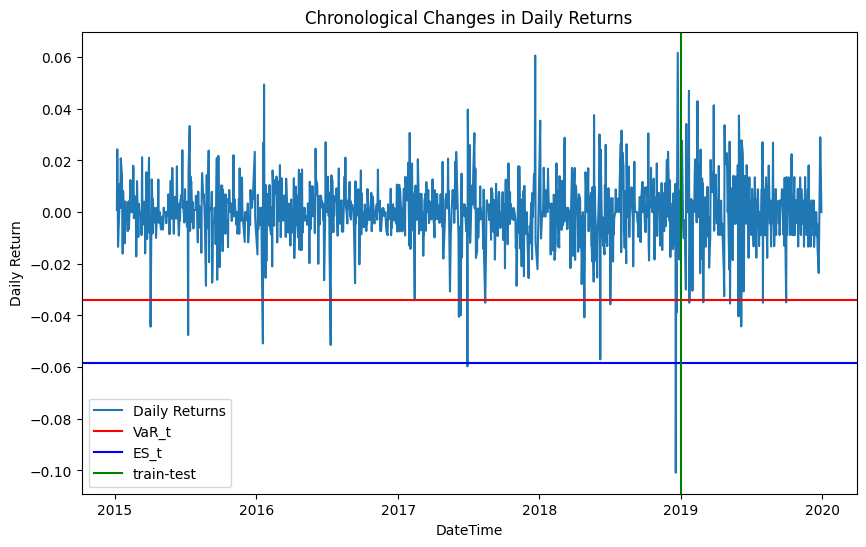

In [133]:
plt.figure(figsize=(10, 6))
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_t, color='r', linestyle='-', label='VaR_t')
plt.axhline(y=ES_t, color='b', linestyle='-', label='ES_t')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

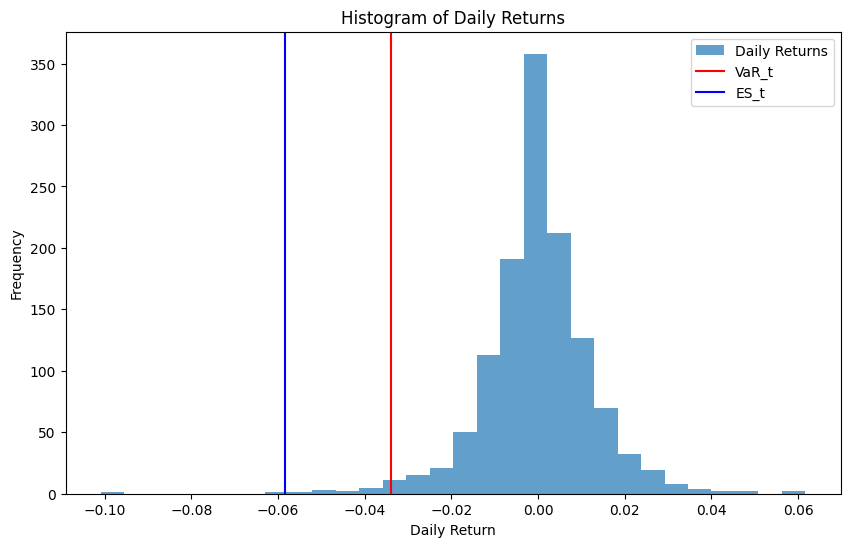

In [134]:
plt.figure(figsize=(10, 6))
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_t, color='r', linestyle='-', label='VaR_t')
plt.axvline(x=ES_t, color='b', linestyle='-', label='ES_t')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

In [136]:
observed_breaches_t = test_data[test_data < VaR_t].count()

md(f"The verification dataset consists of {len(test_data)} data points."
   f" For a confidence threshold of {confidence_level_VaR_ES * 100}% , we would "
   f" anticipate approximately {expected_breaches:.2f} days"
   f" in which losses would surpass the {VaR_t * 100:.2f}% VaR estimate."
   f" However, in the year 2019, the observed count of days with losses "
   f" exceeding the t-Student Distribution-based VaR estimate was {observed_breaches_t}."
   "\n\n"
   f" During the bottom {((1-confidence_level_VaR_ES) * 100):.0f}% of trading days in the verification dataset,"
   f" the average loss (corresponding to ES, estimated by the t-Student Distribution method at {ES_t * 100:.2f}%"
   f") was {ES_per_testdata * 100:.2f}%,"
   f" whereas the upper limit (similar to VaR, estimated by the t-Student Distribution method at {VaR_t * 100:.2f}%"
   f") was {VaR_per_testdata * 100:.2f}%."
   )


The verification dataset consists of 249 data points. For a confidence threshold of 95.0% , we would  anticipate approximately 12.45 days in which losses would surpass the -3.40% VaR estimate. However, in the year 2019, the observed count of days with losses  exceeding the t-Student Distribution-based VaR estimate was 7.

 During the bottom 5% of trading days in the verification dataset, the average loss (corresponding to ES, estimated by the t-Student Distribution method at -5.84%) was -3.34%, whereas the upper limit (similar to VaR, estimated by the t-Student Distribution method at -3.40%) was -2.36%.

The t-Student Distribution method severely overestimated the losses in the worst days, both as average (ES) and as ceiling (VaR). In doing so, it strongly narrowed down the expected number of days with losses beyond VaR. For validation, I compared the number of days when losses exceeded the estimated VaR, versus the 5% expectation imposed by the confidence level.

In [138]:
pvalue_binom_t = binomtest(
  observed_breaches_t, 
  len(test_data), 
  1 - confidence_level_VaR_ES).pvalue
ts_t = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_t
    )
md(f"For the t-Student Distribution method, the p value for the"
   f" log-likelihood Kuipec backtest assessment of the VaR estimate is"
   f" {chi2.sf(ts_t, 1):.2f} in the log-likelihood approach, and "
   f" {pvalue_binom_t:.2f} when using a classical binomial approach."
   )

For the t-Student Distribution method, the p value for the log-likelihood Kuipec backtest assessment of the VaR estimate is 0.09 in the log-likelihood approach, and  0.14 when using a classical binomial approach.

Even in the poorly performing context of the t-Student Distribution estimator, I fail to reject the null hypothesis, meaning that I still have no evidence that the difference between the distribution of observed days exceeding the predicted VaR and the expected number of days with losses exceeding the predicted VaR is statistically significant.

Thus, the VaR estimates based on the Normal Distribution hypothesis are acceptable to the extent that their performance is not inferior to a diffferent model.